In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras import Input
import utils
import metrics

# MNIST dataset params
num_classes = 10 # 0-9 digits
num_features = 784 # img shape: 28*28

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# pre-process data
X_train, y_train, X_test, y_test = utils.preprocess(X_train, y_train, X_test, y_test, num_classes, num_features, print_summary=False)

from tensorflow.keras.utils import to_categorical

# Convert target classes to categorical ones (one-hot encoding) - only for training and tuning
y_train_enc = to_categorical(y_train, num_classes)
y_test_enc = to_categorical(y_test, num_classes)

In [2]:
# network loss function
loss =tf.keras.losses.CategoricalCrossentropy()

# network metrics
eval_metrics = [metrics.f1]

# training batch size
batch_size = 256

# training epochs
epochs = 1000

# print options during training
verbose = 1

# early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

# **$1$. Fine Tuning**

In [ ]:
import keras_tuner

def build_model(hp):

    # hyperparams
    n_hidden_1      =   hp.Choice("units_1", [64, 128])
    n_hidden_2      =   hp.Choice("units_2", [256, 512])
    a_reg           =   hp.Choice("a_reg", [0.1, 0.001, 0.000001])
    learning_rate   =   hp.Choice("learning_rate", [0.1, 0.01, 0.001])

    # mlp model
    mlp_rmsprop_ft = keras.Sequential(name="MLP_RMSProp_FT")

    mlp_rmsprop_ft.add(Input(shape=(num_features,)))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="hidden_layer_1", units=n_hidden_1, activation="relu", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="hidden_layer_2", units=n_hidden_2, activation="relu", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="output_layer", units=num_classes, activation="softmax", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))
    
    mlp_rmsprop_ft.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                            loss=loss, 
                            metrics=eval_metrics)

    return mlp_rmsprop_ft

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    overwrite=True,
    directory="tuning",
    project_name="mlp_tuning",
)

# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_loss",
#     max_trials=12,
#     overwrite=True,
#     directory="tuning",
#     project_name="mlp_tuning",
# )

tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train_enc, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_enc), verbose=verbose, callbacks=[callback])

In [ ]:
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model.summary()
print(best_hyperparameters.get("units_1"))
print(best_hyperparameters.get("units_2"))
print(best_hyperparameters.get("a_reg"))
print(best_hyperparameters.get("learning_rate"))


# **$2$. Optimal Model**

## $a$. Training

In [3]:
# TODO get params from tuning - currently using some random values
n_hidden_1      =   128
n_hidden_2      =   512
a_reg           =   0.001
learning_rate   =   0.001

# mlp model
mlp_rmsprop_opt = keras.Sequential(name="MLP_RMSProp_Opt")

mlp_rmsprop_opt.add(Input(shape=(num_features,)))

mlp_rmsprop_opt.add(keras.layers.Dense(name="hidden_layer_1", units=n_hidden_1, activation="relu", 
                    kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.add(keras.layers.Dense(name="hidden_layer_2", units=n_hidden_2, activation="relu", 
                    kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.add(keras.layers.Dense(name="output_layer", units=num_classes, activation="softmax", 
                    kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                        loss=loss, 
                        metrics=eval_metrics)

history = mlp_rmsprop_opt.fit(X_train, y_train_enc, epochs=100, validation_data=(X_test, y_test_enc))

Epoch 1/100
1750/1750 [==============================] - 5s 3ms/step - loss: 0.6214 - f1: 0.9456 - val_loss: 0.3208 - val_f1: 0.9660
Epoch 2/100
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2939 - f1: 0.9658 - val_loss: 0.2732 - val_f1: 0.9679
Epoch 3/100
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2634 - f1: 0.9694 - val_loss: 0.2857 - val_f1: 0.9627
Epoch 4/100
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2499 - f1: 0.9720 - val_loss: 0.2494 - val_f1: 0.9727
Epoch 5/100
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2443 - f1: 0.9727 - val_loss: 0.2415 - val_f1: 0.9748
Epoch 6/100
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2400 - f1: 0.9736 - val_loss: 0.2395 - val_f1: 0.9742
Epoch 7/100
1750/1750 [==============================] - 6s 3ms/step - loss: 0.2376 - f1: 0.9738 - val_loss: 0.2354 - val_f1: 0.9738
Epoch 8/100
1750/1750 [==============================] - 6s 3ms/step 

## $b$. Results - Evaluation

### $i)$ Confusion Matrix

In [4]:
# predict classes
y_pred = utils.predict_classes(mlp_rmsprop_opt, X_test)

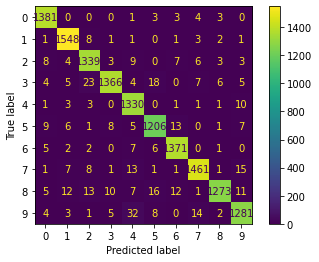

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix_ = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix_).plot()

TN = 125556 
FP = 444 
FN = 444 
TP = 13556 
SUM = 140000
Accuracy = 0.9936571428571429 
Recall = 0.9682857142857143 
Precision = 0.9682857142857143 
F1 = 0.9682857142857143


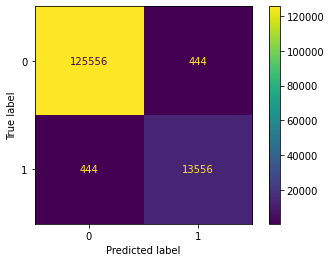

In [7]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

multilabel_confusion_matrix_ = multilabel_confusion_matrix(y_test, y_pred)
confusion_matrix_ = np.sum(multilabel_confusion_matrix_, axis = 0)
ConfusionMatrixDisplay(confusion_matrix_).plot()

tn = confusion_matrix_[0][0]
fp = confusion_matrix_[0][1]
fn = confusion_matrix_[1][0]
tp = confusion_matrix_[1][1]
sum = tn + fp + fn + tp

print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp, "\nSUM =", sum)

accuracy = (tp + tn) / sum
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy =", accuracy, "\nRecall =", recall, "\nPrecision =", precision, "\nF1 =", f1)

### $ii)$ Learning Curves

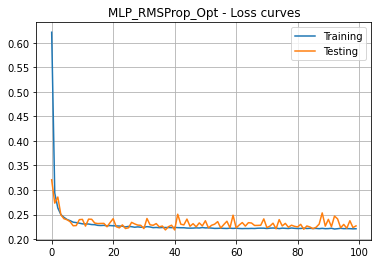

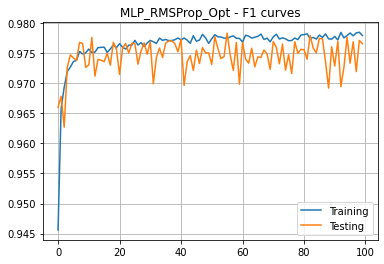

In [8]:
import matplotlib.pyplot as plt

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

f1_train = history.history["f1"]
f1_test = history.history["val_f1"]

plt.ion()

plt.plot(loss_train, label="Training")
plt.plot(loss_test, label="Testing")
plt.title(mlp_rmsprop_opt.name + " - Loss curves")
plt.legend()
plt.grid()
plt.savefig("fig/" + mlp_rmsprop_opt.name + "_Loss.jpg", dpi=1200)
plt.show()

plt.plot(f1_train, label="Training")
plt.plot(f1_test, label="Testing")
plt.title(mlp_rmsprop_opt.name + " - F1 curves")
plt.legend()
plt.grid()
plt.savefig("fig/" + mlp_rmsprop_opt.name + "_F1.jpg", dpi=1200)
plt.show()